In [3]:
import torch.nn as nn
import numpy as np

from torchvision.models import densenet121
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import json
from torchvision.utils import draw_bounding_boxes

In [4]:
PATH = "/home/COVID-19-X-Ray/cache/siim_F2/"
device = 'cuda:0'

class_dict = {'Negative for Pneumonia': 0,
                'Indeterminate Appearance': 2, 
                'Typical Appearance': 1, 
                'Atypical Appearance': 3                 
                }

In [5]:
class DenseNet121(nn.Module):
    def __init__(self, object_path, num_classes=4, ssl=None):
        super(DenseNet121, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = densenet121(pretrained=False, num_classes=num_classes)

        if ssl == "moco":
            ckpt_dict = torch.load(object_path, map_location=device)

            state_dict = ckpt_dict
            for k in list(state_dict.keys()):
                # retain only encoder_q up to before the embedding layer
                if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
                    # remove prefix
                    state_dict[k[len("module.encoder_q."):]] = state_dict[k]
                    # delete renamed or unused k
                    del state_dict[k]
                elif 'encoder_k' in k or 'module.queue' in k:
                    del state_dict[k]
                elif k.startswith('module.encoder_q.fc'):
                    del state_dict[k]

            self.densenet.load_state_dict(state_dict, strict=False)
            
        elif ssl == "inpainting":
            ckpt_dict = torch.load(object_path, map_location=device)

            for k in list(ckpt_dict.keys()):
                # retain only encoder_q up to before the embedding layer
                if k.startswith('encoder.0'):# and not k.startswith('module.encoder_q.fc'):
                    # remove prefix
                    suffix_name =k.split("encoder.0.")[1]
                    new_name = "features." + suffix_name
                    ckpt_dict[new_name] = ckpt_dict.pop(k)

            self.densenet.load_state_dict(ckpt_dict, strict=False)
        
        elif ssl == None:
            ckpt_dict = torch.load(object_path, map_location=device)
            self.densenet.load_state_dict(ckpt_dict, strict=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the model
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [186]:
def convert_coord(bb, od):
    bbx_groups = []
    for i in range(len(bb)):
        x_min = (bb[i]['x']/od[0])*224
        x_max = ((bb[i]['width']/od[0])*224) + x_min
        y_min = (bb[i]['y']/od[1])*224
        y_max = ((bb[i]['height']/od[1])*224) + y_min

        bbx = [x_min, y_min, x_max, y_max]
        bbx_groups.append(bbx)
    bbx_groups = torch.Tensor(bbx_groups)
    return bbx_groups

def load_json_meta(json_id, random_idx):
    json_meta = open(PATH + json_id)
    json_meta = json.load(json_meta)
    
    file_id = json_meta["inputs"][random_idx]
    label = json_meta["targets"][random_idx]
    bbx_list = json_meta["boxes"][random_idx]
    orig_dims = json_meta["orig_dims"][random_idx] 
    
    bbx_list_rescaled = convert_coord(bbx_list, orig_dims)
    
    return file_id, label, bbx_list_rescaled

def load_test_image(file_id):
    img = torch.load(file_id)
    img = img.expand(3,-1,-1)

    test_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(224), int(224)]),
                transforms.ToTensor()])      

    img = test_transform(img).to(device).unsqueeze(0)
    
    return img

def load_image_and_groundtruth(random_idx):
    json_id = PATH.split("/")[-2] + "_val.json"

    file_id, gt_label, bbx_list_rescaled = load_json_meta(json_id, random_idx)

    img = load_test_image(PATH + file_id)    
    
    return img, (file_id, gt_label, bbx_list_rescaled)   

In [7]:
def gradcam_eval(classifier_path, img):
    # initialize the VGG model
    model = DenseNet121(classifier_path, num_classes=4, ssl=None).to(device)

    # set the evaluation mode
    model.eval()

    # get the most likely prediction of the model
    pred = model(img)

    # # https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
    # # get the gradient of the output with respect to the parameters of the model
    pred[0][pred.argmax()].backward()
    
    predicted_class = pred.argmax().cpu().numpy()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img).cpu().detach()
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i].cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    heatmaps = cv2.resize(heatmap.numpy(), (img.shape[-1], img.shape[-2]))
    heatmaps = np.uint8(255 * heatmaps)
    heatmaps = cv2.applyColorMap(heatmaps, cv2.COLORMAP_JET)
    
    img_post = img_grayscale(img)

    superimposed_img = heatmaps * 0.25 + img_post * 0.75
    superimposed_img = np.uint8(superimposed_img)

    return predicted_class, img_post, superimposed_img
    
def img_grayscale(img):
    img_post = img.cpu().numpy()[0,...]
    img_post = np.uint8(255 * img_post)
    img_post = np.moveaxis(img_post, 0, -1)
    
    return img_post

def img_with_bounding_boxes(img, bbx_list):
    colors = ["red" for i in range(len(bbx_list))]
    
    bbx_img = draw_bounding_boxes(
        torch.tensor(img).moveaxis(2,0), 
        bbx_list,
        colors=colors
        )

    img_bbxs = bbx_img.permute(1,2,0)
    
    return img_bbxs

/home/muhammadridzuan/anaconda3/envs/HC701/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


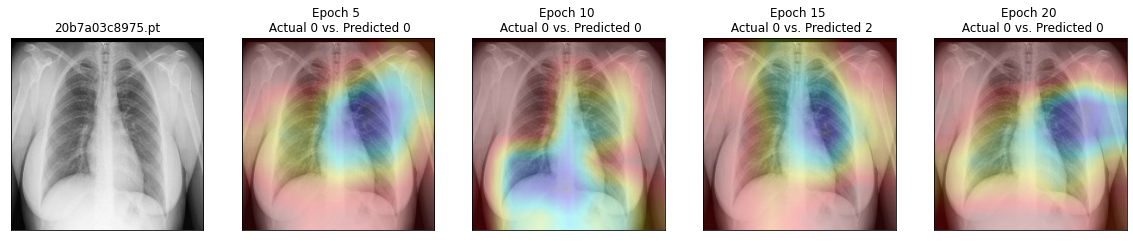

In [8]:
# EPOCHS
# inpainting weights
ep5 = "/home/COVID-19-X-Ray/runs/Nov26_21-23-29_mbzuai-biomedia-hpc1_ip_00011_e5_batch8/classifier_lr_ip_ep5.pt"
ep10 = "/home/COVID-19-X-Ray/runs/Nov27_00-18-51_mbzuai-biomedia-hpc1_ip_00012_e10/classifier_lr_ip_ep10.pt"
ep15 = "/home/COVID-19-X-Ray/runs/Nov26_23-49-56_mbzuai-biomedia-hpc1_ip_00013_e15/classifier_lr_ip_ep15.pt"
ep20 = "/home/COVID-19-X-Ray/runs/Nov26_22-03-16_mbzuai-biomedia-hpc1_ip_00014_e20/best_classifier_lr_ip_ep20.pt"

# get random image
random_idx = np.random.randint(0, 1263)

experiments_list = [ep5, ep10, ep15, ep20]
plt.figure(figsize=(20,10*len(experiments_list)))

for i, classifier_path in enumerate(experiments_list):
    img, (file_id, gt_label, bbx_list) = load_image_and_groundtruth(random_idx)

    predicted_class, img_gray, gradcam_img = gradcam_eval(classifier_path, img)
    
    gradcam_img = img_with_bounding_boxes(gradcam_img, bbx_list)

    plt.subplot(1, 5, i+2, xticks=[], yticks=[])
    plt.imshow(gradcam_img, cmap='gray', vmin=0, vmax=1)
    plt.title("Epoch {} \n Actual {} vs. Predicted {}".format((i+1)*5, gt_label, predicted_class))


plt.subplot(1, 5, 1, xticks=[], yticks=[])
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.title(file_id)
plt.show()

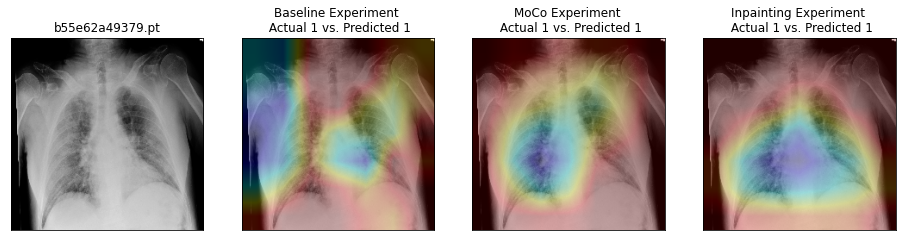

{'Negative for Pneumonia': 0, 'Indeterminate Appearance': 2, 'Typical Appearance': 1, 'Atypical Appearance': 3}
714 b55e62a49379.pt


In [147]:
# inpainting weights
best_baseline = "/home/COVID-19-X-Ray/HC701/inpainting_project/test_weights/best_baseline_classifier.pt"
best_moco = "/home/COVID-19-X-Ray/HC701/inpainting_project/test_weights/mocov2_f2_10.pt"
# best_moco = "/home/muhammadridzuan/TB-X-Ray/COVID-19-X-Ray/HC701/inpainting_project/test_weights/MoCo_F1_000016.pt"
best_inpainting = "/home/COVID-19-X-Ray/runs/Nov26_22-03-16_mbzuai-biomedia-hpc1_ip_00014_e20/best_classifier_lr_ip_ep20.pt"

idx = np.random.randint(0, 1263)

experiments_list = [best_baseline, best_moco, best_inpainting]
experiments_names = ["Baseline", "MoCo", "Inpainting"]
plt.figure(figsize=(20, 10*len(experiments_list)))
plt.title("Baseline vs MoCo vs Inpainting")

for i, (classifier_path, experiment_name) in enumerate(list(zip(experiments_list, experiments_names))):
        
    img, (file_id, gt_label, bbx_list) = load_image_and_groundtruth(idx)

    predicted_class, img_gray, gradcam_img = gradcam_eval(classifier_path, img)
    
    plt.subplot(1, 5, i+2, xticks=[], yticks=[])
    plt.imshow(gradcam_img, cmap='gray', vmin=0, vmax=1)
    plt.title("{} Experiment \n Actual {} vs. Predicted {}".format(experiment_name, gt_label, predicted_class), fontdict = {"color": "black"})
    # plt.show()

plt.subplot(1, 5, 1, xticks=[], yticks=[])
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.title(file_id, fontdict = {"color": "black"})
plt.show()

print('{}'.format(class_dict))
print(random_idx, file_id)

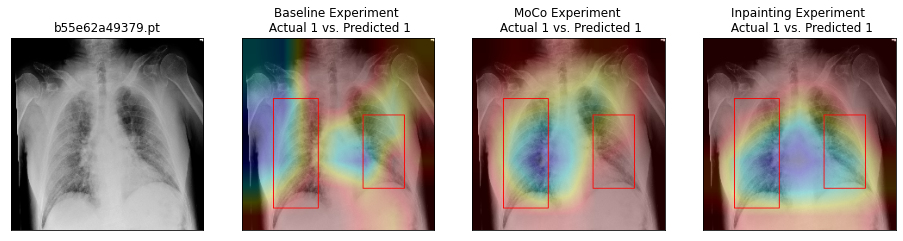

{'Negative for Pneumonia': 0, 'Indeterminate Appearance': 2, 'Typical Appearance': 1, 'Atypical Appearance': 3}
714 b55e62a49379.pt


In [148]:
# with bbx
experiments_list = [best_baseline, best_moco, best_inpainting]
experiments_names = ["Baseline", "MoCo", "Inpainting"]
plt.figure(figsize=(20, 10*len(experiments_list)))
plt.title("Baseline vs MoCo vs Inpainting")

for i, (classifier_path, experiment_name) in enumerate(list(zip(experiments_list, experiments_names))):
        
    img, (file_id, gt_label, bbx_list) = load_image_and_groundtruth(idx)

    predicted_class, img_gray, gradcam_img = gradcam_eval(classifier_path, img)
    
    gradcam_img = img_with_bounding_boxes(gradcam_img, bbx_list)

    plt.subplot(1, 5, i+2, xticks=[], yticks=[])
    plt.imshow(gradcam_img, cmap='gray', vmin=0, vmax=1)
    plt.title("{} Experiment \n Actual {} vs. Predicted {}".format(experiment_name, gt_label, predicted_class), fontdict = {"color": "black"})
    # plt.show()

plt.subplot(1, 5, 1, xticks=[], yticks=[])
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.title(file_id, fontdict = {"color": "black"})
plt.show()

print('{}'.format(class_dict))
print(random_idx, file_id)